In [300]:
import os 
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

os.chdir('/Users/kaushalk/Desktop/open_projects/Telengana_Crop_Health/')
# Add the 'src' directory to the Python path
from src.process_data import compute_indices_for_df, prepare_model_data, compute_monthly_indices_for_df
from src.visualize import plot_numerical_distributions, plot_confusion_matrix
from src.utils import FocalLoss

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## Deep learning package 
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
from torchmetrics.classification import Accuracy

from torch.utils.data import Dataset, DataLoader, random_split

In [302]:
df = pd.read_csv('data/Model/Input/train_monthly_indeces.csv', index_col=0)
# Identify time-series columns (all M1-M23 features)
columns_to_drop = [col for col in df.columns if 'LSWI' in col or 'LCI' in col or 'MoistureIndex' in col]
df = df.drop(columns=columns_to_drop)

time_series_columns = [col for col in df.columns if col.startswith("M")]

# Ensure `HDate` is numeric
df["HDate"] = pd.to_datetime(df["HDate"], errors='coerce').dt.month

# Category Mapping
category_mapper = {'Healthy': 0, 'Diseased': 1, 'Pests': 2, 'Stressed': 3}
df["category"] = df["category"].map(category_mapper)
df = df.dropna(subset=['M1_EVI'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7866 entries, 0 to 7887
Data columns (total 89 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FarmID           7866 non-null   int64  
 1   category         7866 non-null   int64  
 2   Crop             7866 non-null   object 
 3   State            7866 non-null   object 
 4   District         7866 non-null   object 
 5   Sub-District     7866 non-null   object 
 6   SDate            7866 non-null   object 
 7   HDate            7866 non-null   int32  
 8   CropCoveredArea  7866 non-null   int64  
 9   CHeight          7866 non-null   int64  
 10  CNext            7866 non-null   object 
 11  CLast            7866 non-null   object 
 12  CTransp          7866 non-null   object 
 13  IrriType         7866 non-null   object 
 14  IrriSource       7866 non-null   object 
 15  IrriCount        7866 non-null   int64  
 16  WaterCov         7866 non-null   int64  
 17  ExpYield         78

In [304]:
num_farms = df.FarmID.nunique()
# Extract Time-Series Features (EVI, NDRE, GNDVI for 23 months)
time_series_cols = [col for col in df.columns if col.startswith('M')]
X = df[time_series_cols].fillna(0).values.reshape(num_farms, 23, 3)  # (Farms, TimeSteps=23, Features=3)
y = df['category'].values  # (Farms, ) - Multi-Class Labels
X.shape, y.shape

((7866, 23, 3), (7866,))

In [349]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.data import DataLoader, TensorDataset
# Split into train and validation sets (80% Train, 20% Validation)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)

# Create Dataloaders
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

# Balance Class while training
class_counts = np.bincount(y_train)
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size,  sampler=sampler)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

## Deep Learning Models

In [352]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

In [354]:
# Use MPS if available (Mac M3 optimization)
device = torch.device("mps" if torch.backends.mps.is_available() 
                      else "cuda" if torch.cuda.is_available() else "cpu")

In [356]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, TensorDataset
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# Check device compatibility for Mac M3
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

class FPN1D_Lightning(pl.LightningModule):
    def __init__(self, input_channels, sequence_length, num_classes=4, lr=0.0008):
        super(FPN1D_Lightning, self).__init__()
        self.lr = lr

        # Bottom-Up Pathway
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=2, padding=1)

        # Lateral Connections
        self.lateral2 = nn.Conv1d(128, 128, kernel_size=1)
        self.lateral1 = nn.Conv1d(64, 64, kernel_size=1)

        # Top-Down Pathway
        self.up2 = nn.Conv1d(256, 128, kernel_size=1)
        self.up1 = nn.Conv1d(128, 64, kernel_size=1)

        # Fully Connected Layers
        self.fc = nn.Linear(64 * sequence_length, 128)
        self.out = nn.Linear(128, num_classes)

        self.criterion = FocalLoss()

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, channels, time)
        
        # Bottom-Up Pathway
        c1 = F.relu(self.conv1(x))
        c2 = F.relu(self.conv2(c1))
        c3 = F.relu(self.conv3(c2))

        # Top-Down Pathway
        p2 = self.up2(c3)
        p2 = F.interpolate(p2, size=c2.shape[2], mode="linear", align_corners=False)
        p2 = F.relu(p2 + self.lateral2(c2))

        p1 = self.up1(p2)
        p1 = F.interpolate(p1, size=c1.shape[2], mode="linear", align_corners=False)
        p1 = F.relu(p1 + self.lateral1(c1))

        # Feature Extraction
        r1 = p1.view(p1.shape[0], -1)
        features = self.fc(r1)
        output = self.out(features)

        return output

    def training_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X_batch, y_batch = batch
        outputs = self(X_batch)
        loss = self.criterion(outputs, y_batch)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.RMSprop(self.parameters(), lr=self.lr, weight_decay=0.00014)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)  #StepLR(optimizer, step_size=10, gamma=0.65)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [358]:
# Logger & Checkpoints
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar

logger = TensorBoardLogger("lightning_logs", name="FPN1D_Fnl")

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename="fpn1d_best-final",
    save_top_k=1,
    mode="min"
)

early_stopping_callback = EarlyStopping(monitor="val_loss", patience=20, mode="min")
progress_bar = RichProgressBar()

In [360]:
# Training
model = FPN1D_Lightning(input_channels=X_train_tensor.shape[2], sequence_length=X_train_tensor.shape[1], lr=0.003)

trainer = pl.Trainer(
    max_epochs=50,
    devices=1,
    accelerator="mps" if torch.backends.mps.is_available() else "cpu",
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback, progress_bar],
    enable_progress_bar=True
)

trainer.fit(model, train_loader, valid_loader)

Epoch 23/49 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394/394 0:00:05 • 0:00:00 76.40it/s v_num: 3.000 train_loss: 0.553    
                                                                                 val_loss: 0.757                   

In [369]:
checkpoint_callback.best_model_path

'/Users/kaushalk/Desktop/open_projects/Telengana_Crop_Health/checkpoints/fpn1d_best-final-v3.ckpt'

In [371]:
# Load Best Model from Checkpoint
best_model_path = checkpoint_callback.best_model_path  # This gives the best checkpoint path

# Load model with necessary parameters
fpn_model = FPN1D_Lightning.load_from_checkpoint(
    best_model_path, 
    input_channels=3, 
    sequence_length=23
)
fpn_model.eval()
model.to(device)

FPN1D_Lightning(
  (conv1): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
  (lateral2): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (lateral1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
  (up2): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
  (up1): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (fc): Linear(in_features=1472, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=4, bias=True)
  (criterion): FocalLoss(
    (ce_loss): CrossEntropyLoss()
  )
)

In [373]:
# Lists to store predictions and ground truth labels
y_preds = []
y_true = []

# Evaluation Loop
with torch.no_grad():
    for X_batch, y_batch in valid_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)

        y_preds.extend(predicted.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

In [375]:
# Generate Classification Report
classification_rep = classification_report(y_true, y_preds, digits=2)
conf_matrix = confusion_matrix(y_true, y_preds)
accuracy = accuracy_score(y_true, y_preds)
f1 = f1_score(y_true, y_preds, average="weighted")

# Print Results
print("\n🔹 Classification Report:\n", classification_rep)
print("\n✅ Accuracy:", accuracy)
print("✅ Weighted F1 Score:", f1)


🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.11      0.19      1298
           1       0.03      0.06      0.04        95
           2       0.07      0.51      0.12        97
           3       0.06      0.37      0.10        84

    accuracy                           0.14      1574
   macro avg       0.25      0.26      0.11      1574
weighted avg       0.71      0.14      0.17      1574


✅ Accuracy: 0.14167725540025414
✅ Weighted F1 Score: 0.1704470492598453


### FPN HP Tuning 

In [343]:
import optuna
from optuna.trial import Trial
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, RichProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import torch.nn as nn
from typing import Dict, Any

class HyperparameterTuner:
    def __init__(
        self,
        X_train_tensor,
        train_loader,
        valid_loader,
        n_trials=50,
        study_name="fpn1d_optimization",
        storage_name="sqlite:///fpn1d_tuning.db"
    ):
        self.X_train_tensor = X_train_tensor
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.n_trials = n_trials
        self.study_name = study_name
        self.storage_name = storage_name
        
    def objective(self, trial: Trial) -> float:
        # Hyperparameter search space
        config = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True),
            "weight_decay": trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True),
            "scheduler_step_size": trial.suggest_int("scheduler_step_size", 5, 15),
            "scheduler_gamma": trial.suggest_float("scheduler_gamma", 0.5, 0.9),
            "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
            "optimizer": trial.suggest_categorical("optimizer", ["Adam", "AdamW", "RMSprop"])
        }
        
        # Model configuration
        model = FPN1D_Lightning(
            input_channels=self.X_train_tensor.shape[2],
            sequence_length=self.X_train_tensor.shape[1],
            lr=config["learning_rate"]
        )
        
        # Training configuration
        logger = TensorBoardLogger(
            save_dir="lightning_logs",
            name=f"trial_{trial.number}",
            version=f"v{trial.number}"
        )
        
        checkpoint_callback = ModelCheckpoint(
            monitor="val_loss",
            dirpath=f"checkpoints/trial_{trial.number}",
            filename=f"fpn1d_trial_{trial.number}_best",
            save_top_k=1,
            mode="min"
        )
        
        early_stopping = EarlyStopping(
            monitor="val_loss",
            patience=3,
            mode="min"
        )
        
        # Configure optimizer and scheduler
        def configure_optimizers(model):
            optimizers = {
                "Adam": torch.optim.Adam,
                "AdamW": torch.optim.AdamW,
                "RMSprop": torch.optim.RMSprop
            }
            
            optimizer = optimizers[config["optimizer"]](
                model.parameters(),
                lr=config["learning_rate"],
                weight_decay=config["weight_decay"]
            )
            
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer,
                step_size=config["scheduler_step_size"],
                gamma=config["scheduler_gamma"]
            )
            
            return {"optimizer": optimizer, "lr_scheduler": scheduler}
        
        model.configure_optimizers = lambda: configure_optimizers(model)
        
        # Trainer
        trainer = pl.Trainer(
            max_epochs=30,
            devices=1,
            accelerator="mps" if torch.backends.mps.is_available() else "cpu",
            logger=logger,
            callbacks=[checkpoint_callback, early_stopping, RichProgressBar()],
            enable_progress_bar=True
        )
        
        # Train and evaluate
        trainer.fit(model, self.train_loader, self.valid_loader)
        
        # Return the best validation loss
        return checkpoint_callback.best_model_score.item()
    
    def run_study(self) -> Dict[str, Any]:
        study = optuna.create_study(
            study_name=self.study_name,
            storage=self.storage_name,
            direction="minimize",
            load_if_exists=True
        )
        
        study.optimize(self.objective, n_trials=self.n_trials)
        
        # Get best parameters and results
        best_params = study.best_params
        best_value = study.best_value
        
        # Print optimization results
        print("\nBest trial:")
        print(f"Value: {best_value:.4f}")
        print("\nBest hyperparameters:")
        for param, value in best_params.items():
            print(f"{param}: {value}")
            
        return {
            "best_params": best_params,
            "best_value": best_value,
            "study": study
        }

    def plot_optimization_history(self, study):
        import optuna.visualization as vis
        
        # Plot optimization history
        fig_history = vis.plot_optimization_history(study)
        fig_history.show()
        
        # Plot parameter importances
        fig_importance = vis.plot_param_importances(study)
        fig_importance.show()
        
        # Plot parallel coordinate plot
        fig_parallel = vis.plot_parallel_coordinate(study)
        fig_parallel.show()



In [345]:
# Usage example
def run_hyperparameter_tuning(X_train_tensor, train_loader, valid_loader):
    tuner = HyperparameterTuner(
        X_train_tensor=X_train_tensor,
        train_loader=train_loader,
        valid_loader=valid_loader,
        n_trials=20
    )
    
    results = tuner.run_study()
    tuner.plot_optimization_history(results["study"])
    
    return results

Epoch 6/29 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197/197 0:00:02 • 0:00:00 67.57it/s v_num: v72 train_loss: 0.719      
                                                                                 val_loss: 0.817                   

[I 2025-02-09 13:03:34,974] Trial 72 finished with value: 0.7301933765411377 and parameters: {'learning_rate': 0.00042847027683886343, 'weight_decay': 0.00032855617086930756, 'scheduler_step_size': 11, 'scheduler_gamma': 0.7891006160624068, 'batch_size': 16, 'optimizer': 'Adam'}. Best is trial 56 with value: 0.6185992360115051.



Best trial:
Value: 0.6186

Best hyperparameters:
learning_rate: 0.0031396998489935544
weight_decay: 0.00014092886811511684
scheduler_step_size: 15
scheduler_gamma: 0.8966127848310197
batch_size: 16
optimizer: RMSprop


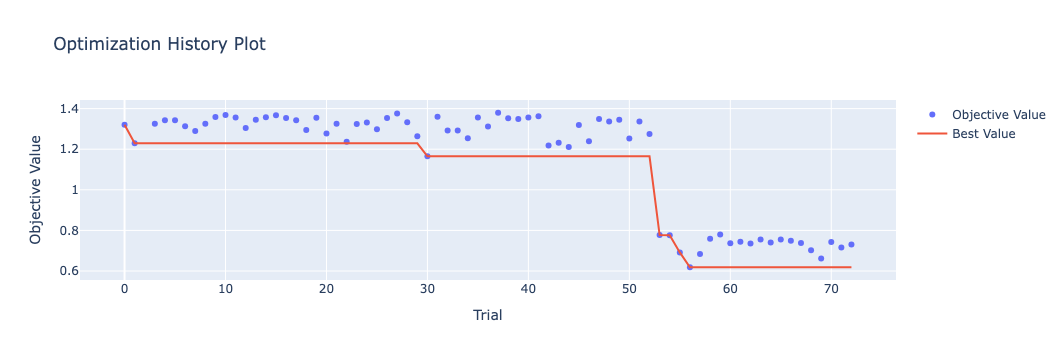

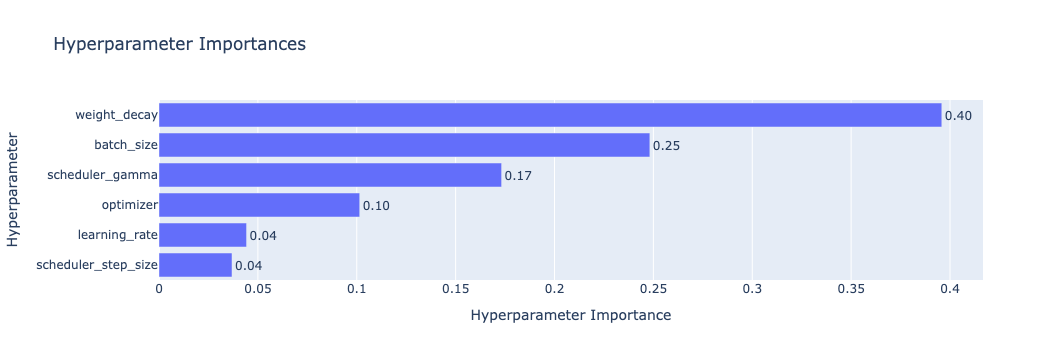

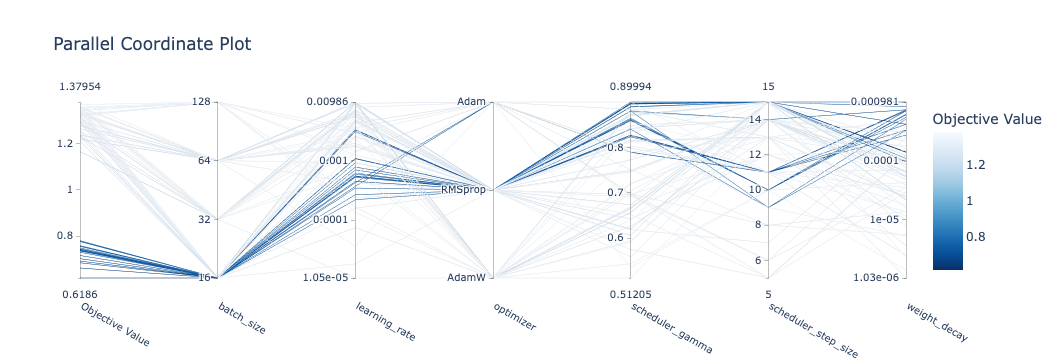

In [347]:
results = run_hyperparameter_tuning(X_train_tensor, train_loader, valid_loader)

### U-NET Tuning 

In [267]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block to enhance channel-wise features."""
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        w = F.adaptive_avg_pool1d(x, 1).squeeze(-1)  # [B, C]
        w = F.relu(self.fc1(w))
        w = torch.sigmoid(self.fc2(w)).unsqueeze(-1)
        return x * w  # Channel-wise attention

class UNet1D_Improved(nn.Module):
    def __init__(self, input_channels=3, seq_length=23, num_classes=4):
        super(UNet1D_Improved, self).__init__()

        self.conv1 = nn.Conv1d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.se1 = SEBlock(32)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, dilation=2, padding=2)  # Dilated Conv
        self.bn2 = nn.BatchNorm1d(64)
        self.se2 = SEBlock(64)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, dilation=2, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.se3 = SEBlock(128)

        self.pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        x = F.relu(self.bn1(self.conv1(x)))
        x = self.se1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.se2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.se3(x)

        x = self.pool(x).squeeze(-1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [293]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

class ImbalancedUNetTuner:
    def __init__(
        self,
        train_loader: DataLoader,
        valid_loader: DataLoader,
        input_channels: int,
        seq_length: int,
        num_classes: int,
        device: torch.device,
        checkpoint_dir: str = "model_checkpoints",
        n_trials: int = 20,
        study_name: str = "unet_focal_loss_optimization"
    ):
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.input_channels = input_channels
        self.seq_length = seq_length
        self.num_classes = num_classes
        self.device = device
        self.n_trials = n_trials
        self.study_name = study_name
        
        # Initialize checkpointing
        self.checkpoint_callback = ModelCheckpoint(
            dirpath=checkpoint_dir,
            filename_prefix="unet_focal",
            monitor='balanced_acc',
            mode='max'
        )
        
        # Create TensorBoard logger
        self.tensorboard_dir = os.path.join(checkpoint_dir, 'tensorboard_logs')
        os.makedirs(self.tensorboard_dir, exist_ok=True)
    
    def create_model(self, trial: Trial) -> UNet1D_Improved:
        # Model architecture hyperparameters
        se_reduction = trial.suggest_int("se_reduction", 4, 32)
        dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
        initial_channels = trial.suggest_categorical("initial_channels", [16, 32, 64])
        dilation_rate = trial.suggest_int("dilation_rate", 1, 4)
        
        model = UNet1D_Improved(
            input_channels=self.input_channels,
            seq_length=self.seq_length,
            num_classes=self.num_classes
        )
        return model.to(self.device)
    
    def create_criterion(self, config):
        return FocalLoss()
    
    def create_optimizer(self, model, config):
        optimizers = {
            "Adam": lambda params, lr, wd: torch.optim.Adam(
                params, lr=lr, weight_decay=wd, eps=1e-7
            ),
            "AdamW": lambda params, lr, wd: torch.optim.AdamW(
                params, lr=lr, weight_decay=wd, eps=1e-7
            )
        }
        
        return optimizers[config["optimizer_name"]](
            model.parameters(),
            lr=config["learning_rate"],
            wd=config["weight_decay"]
        )

    def train_epoch(self, model, optimizer, criterion, scheduler):
        """Run one training epoch"""
        model.train()
        total_loss = 0.0
        num_batches = len(self.train_loader)
        
        for i, (X_batch, y_batch) in enumerate(self.train_loader):
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            # Accumulate loss
            total_loss += loss.item()
            
        return total_loss / num_batches

    def validate_epoch(self, model, criterion):
        """Run one validation epoch"""
        model.eval()
        total_loss = 0.0
        all_predictions = []
        all_targets = []
        num_batches = len(self.valid_loader)
        
        with torch.no_grad():
            for X_batch, y_batch in self.valid_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                
                # Forward pass
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                
                # Store predictions and targets for metrics
                predictions = outputs.argmax(dim=1)
                all_predictions.extend(predictions.cpu().numpy())
                all_targets.extend(y_batch.cpu().numpy())
                
                # Accumulate loss
                total_loss += loss.item()
        
        # Calculate metrics
        balanced_acc = balanced_accuracy_score(all_targets, all_predictions)
        confusion_mat = confusion_matrix(all_targets, all_predictions)
        
        return total_loss / num_batches, balanced_acc, confusion_mat

    def plot_confusion_matrix(self, confusion_mat):
        """Plot confusion matrix using seaborn"""
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        return plt.gcf()

    def save_model(self, model, trial_number, balanced_acc):
        """Save model checkpoint"""
        checkpoint_path = os.path.join(
            self.checkpoint_dir, 
            f'model_trial_{trial_number}_acc_{balanced_acc:.4f}.pt'
        )
        torch.save({
            'model_state_dict': model.state_dict(),
            'balanced_acc': balanced_acc,
            'trial_number': trial_number
        }, checkpoint_path)

    def load_best_model(self):
        """Load the best model from checkpoints"""
        best_model_path = os.path.join(self.checkpoint_callback.dirpath, "unet_focal_best.pth")
        if os.path.exists(best_model_path):
            checkpoint = torch.load(best_model_path)
            model = UNet1D_Improved(
                input_channels=self.input_channels,
                seq_length=self.seq_length,
                num_classes=self.num_classes
            ).to(self.device)
            model.load_state_dict(checkpoint['model_state_dict'])
            return model, checkpoint['trial_params'], checkpoint['score']
        else:
            raise FileNotFoundError("No best model checkpoint found")
    
    def create_scheduler(self, optimizer, config):
        return torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=config["learning_rate"],
            epochs=30,
            steps_per_epoch=len(self.train_loader),
            pct_start=0.3,
            div_factor=25.0,
            final_div_factor=1e4
        )
    
    def objective(self, trial: Trial) -> float:
        writer = SummaryWriter(os.path.join(self.tensorboard_dir, f'trial_{trial.number}'))
        
        # Hyperparameter search space
        config = {
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
            "weight_decay": trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True),
            "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64]),
            "optimizer_name": trial.suggest_categorical("optimizer", ["Adam", "AdamW"]),
        }
        
        model = self.create_model(trial)
        optimizer = self.create_optimizer(model, config)
        scheduler = self.create_scheduler(optimizer, config)
        criterion = self.create_criterion(config)
        
        best_balanced_acc = 0.0
        patience = 7  # Increased patience for better convergence
        patience_counter = 0
        
        for epoch in range(30):
            # Training phase
            train_loss = self.train_epoch(model, optimizer, criterion, scheduler)
            
            # Validation phase
            val_loss, balanced_acc, confusion_mat = self.validate_epoch(model, criterion)
            
            # Log metrics
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Loss/validation', val_loss, epoch)
            writer.add_scalar('Metrics/balanced_accuracy', balanced_acc, epoch)
            
            # Log confusion matrix periodically
            if epoch % 5 == 0:
                fig = self.plot_confusion_matrix(confusion_mat)
                writer.add_figure('Confusion Matrix', fig, epoch)
                plt.close(fig)
            
            # Handle checkpointing
            if self.checkpoint_callback.update(balanced_acc, model, trial.number, config):
                best_balanced_acc = balanced_acc
                patience_counter = 0
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= patience:
                break
            
            trial.report(-balanced_acc, epoch)
            if trial.should_prune():
                writer.close()
                raise optuna.TrialPruned()
        
        writer.close()
        return -best_balanced_acc

    def run_study(self):
        study = optuna.create_study(
            study_name=self.study_name,
            direction="minimize",
            pruner=optuna.pruners.MedianPruner(n_startup_trials=5)
        )
        
        study.optimize(self.objective, n_trials=self.n_trials)
        
        # Print results
        print("\nBest trial:")
        trial = study.best_trial
        print(f"Balanced Accuracy: {-trial.value:.4f}")
        print("\nBest hyperparameters:")
        for param, value in trial.params.items():
            print(f"{param}: {value}")
        
        return study


In [295]:
# Usage example
def run_unet_focal_tuning(
    train_loader, 
    valid_loader, 
    input_channels, 
    seq_length, 
    num_classes, 
    device,
    checkpoint_dir="model_checkpoints"
):
    tuner = ImbalancedUNetTuner(
        train_loader=train_loader,
        valid_loader=valid_loader,
        input_channels=input_channels,
        seq_length=seq_length,
        num_classes=num_classes,
        device=device,
        checkpoint_dir=checkpoint_dir,
        n_trials=20
    )
    
    study = tuner.run_study()
    
    # Load best model
    best_model, best_params, best_score = tuner.load_best_model()
    
    return {
        "study": study,
        "best_model": best_model,
        "best_params": best_params,
        "best_score": best_score
    }

In [297]:
unet_results = run_unet_focal_tuning(
    train_loader=train_loader,
    valid_loader=valid_loader,
    input_channels=3,
    seq_length=23,
    num_classes=4,
    device=device,
    checkpoint_dir="model_checkpoints"
)

[I 2025-02-09 12:23:26,914] A new study created in memory with name: unet_focal_loss_optimization
[I 2025-02-09 12:24:53,336] Trial 0 finished with value: -0.28232109758694546 and parameters: {'learning_rate': 0.0025106912081889828, 'weight_decay': 0.00010750072867778556, 'batch_size': 64, 'optimizer': 'Adam', 'se_reduction': 26, 'dropout_rate': 0.38807547669399345, 'initial_channels': 32, 'dilation_rate': 2}. Best is trial 0 with value: -0.28232109758694546.
[I 2025-02-09 12:26:00,552] Trial 1 finished with value: -0.2843787521278853 and parameters: {'learning_rate': 0.0006169042838943542, 'weight_decay': 0.00010551331566353282, 'batch_size': 64, 'optimizer': 'Adam', 'se_reduction': 9, 'dropout_rate': 0.4734019454205324, 'initial_channels': 32, 'dilation_rate': 2}. Best is trial 1 with value: -0.2843787521278853.
[I 2025-02-09 12:26:37,480] Trial 2 finished with value: -0.0 and parameters: {'learning_rate': 0.00016061695353599765, 'weight_decay': 5.35760424009688e-05, 'batch_size': 16


Best trial:
Balanced Accuracy: 0.2844

Best hyperparameters:
learning_rate: 0.0006169042838943542
weight_decay: 0.00010551331566353282
batch_size: 64
optimizer: Adam
se_reduction: 9
dropout_rate: 0.4734019454205324
initial_channels: 32
dilation_rate: 2


/var/folders/6s/pmgl89tn2bz6y4blfg2jymbh0000gn/T/ipykernel_26697/3347232833.py:150: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [364]:
unet_results

{'study': <optuna.study.study.Study at 0x38cfb9db0>,
 'best_model': UNet1D_Improved(
   (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,))
   (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (se1): SEBlock(
     (fc1): Linear(in_features=32, out_features=2, bias=True)
     (fc2): Linear(in_features=2, out_features=32, bias=True)
   )
   (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
   (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (se2): SEBlock(
     (fc1): Linear(in_features=64, out_features=4, bias=True)
     (fc2): Linear(in_features=4, out_features=64, bias=True)
   )
   (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
   (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (se3): SEBlock(
     (fc1): Linear(in_features=128, out_features=8, bias=True)
     (fc2): Linear(i